Pareto k summary:
  mean=-0.082  median=-0.089  max=0.688

Empirical 90% coverage:
  Credible (posterior predictive): 0.917
  PSIS-Conformal:                 0.903
Conformal q (90% target): 0.572


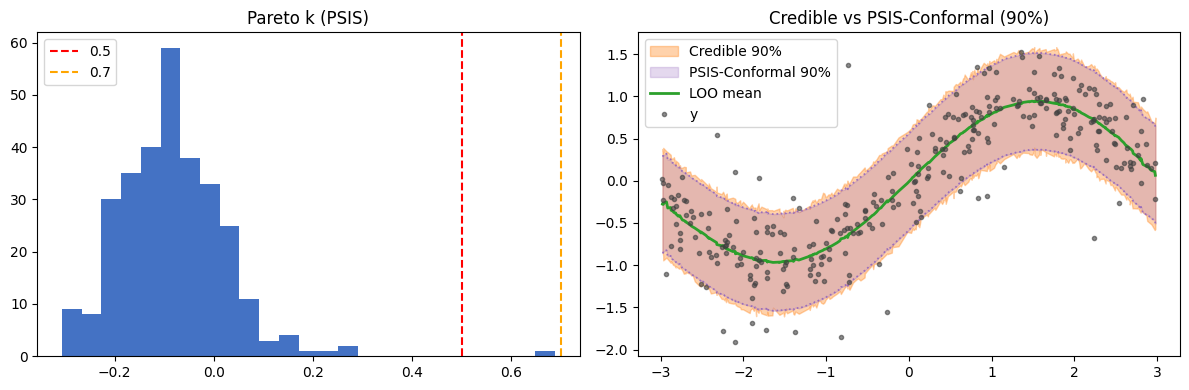

In [1]:
# PSIS-LOO Conformal Prediction Demo
# - Implements PSIS weights with GPD tail smoothing + Ionides truncation
# - Builds LOO residuals and conformal intervals
# - Demonstrates on a sinusoidal regression with heavy-tailed noise
# - Uses a conjugate Bayesian Linear Regression to generate posterior draws

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
from scipy.special import logsumexp

# -------------------------------
# Utilities: PSIS
# -------------------------------

def _normal_logpdf(y, mu, sigma, eps=1e-12):
    y = np.asarray(y, dtype=float)
    mu = np.asarray(mu, dtype=float)
    sigma = np.asarray(sigma, dtype=float)
    sigma = np.maximum(sigma, eps)
    var = sigma**2
    return -0.5 * (np.log(2.0 * np.pi * var) + ((y - mu) ** 2) / var)

def psis_smooth_weights_single(
    log_lik_i: np.ndarray,
    tail_fraction: float = 0.2,
    min_tail: int = 20,
    ionides_trunc: bool = True,
    eps: float = 1e-12,
):
    """
    PSIS weights for a single observation i.
    Input:
      - log_lik_i: (S,) log p(y_i | theta_s)
    Returns:
      - w: (S,) normalized PSIS weights
      - k_hat: Pareto shape parameter (diagnostic)
    """
    ll = np.asarray(log_lik_i, dtype=float).reshape(-1)
    S = ll.shape[0]
    if S == 0:
        raise ValueError("Empty log_lik_i")

    # Importance ratios r_s ∝ 1 / p(y_i | theta_s) = exp(-loglik)
    # Stabilize in log space: log r = -ll, then subtract max
    log_r = -ll
    log_r -= np.max(log_r)
    r = np.exp(log_r)
    r = np.maximum(r, eps)

    # Tail size
    m = max(min_tail, int(np.floor(tail_fraction * S)))
    m = min(m, S)
    if m == 0:
        w = r / np.sum(r)
        return w, np.nan

    # Sort weights, smooth top tail with GPD expected order stats
    order = np.argsort(r)
    r_sorted = r[order]
    tail = r_sorted[-m:]
    u = r_sorted[-m]  # threshold (minimum of tail)

    k_hat = np.nan
    if m >= 5 and np.any(tail > u):
        y_excess = tail - u
        try:
            # Fit GPD on exceedances with loc=0
            c, loc, scale = genpareto.fit(y_excess, floc=0.0)
            k_hat = float(c)
            # Expected order statistic positions
            p = (np.arange(1, m + 1) - 0.5) / m
            tail_smooth = u + genpareto.ppf(p, c, loc=0.0, scale=scale)
            tail_smooth = np.clip(tail_smooth, 0.0, np.inf)
            r_sorted[-m:] = tail_smooth
        except Exception:
            pass  # fall back to unsmoothed tail if fit fails

    # Ionides truncation to control variance
    if ionides_trunc:
        tau = (S ** 0.75) * np.mean(r_sorted)
        r_sorted = np.minimum(r_sorted, tau)

    # Unsort back
    r_smoothed = np.empty_like(r_sorted)
    r_smoothed[order] = r_sorted

    # Normalize
    total = np.sum(r_smoothed)
    total = max(total, eps)
    w = r_smoothed / total
    return w, k_hat

def psis_weights_matrix(
    log_lik: np.ndarray,
    tail_fraction: float = 0.2,
    min_tail: int = 20,
    ionides_trunc: bool = True,
):
    """
    Compute PSIS weights for all observations.
    Input:
      - log_lik: (n, S) log p(y_i | theta_s)
    Returns:
      - W: (n, S) normalized PSIS weights
      - k: (n,) Pareto shape diagnostics
    """
    ll = np.asarray(log_lik, dtype=float)
    if ll.ndim != 2:
        raise ValueError("log_lik must be (n, S)")
    n, S = ll.shape
    W = np.empty((n, S), dtype=float)
    k = np.empty(n, dtype=float)

    for i in range(n):
        w_i, k_i = psis_smooth_weights_single(
            ll[i], tail_fraction=tail_fraction, min_tail=min_tail, ionides_trunc=ionides_trunc
        )
        W[i] = w_i
        k[i] = k_i
    return W, k

# -------------------------------
# Utilities: LOO + Conformal
# -------------------------------

def loo_predictions(y_pred: np.ndarray, w_tilde: np.ndarray):
    """
    LOO predictive mean per observation i: sum_s w_i,s * y_pred[i,s]
    y_pred: (n, S), predictive mean draws f_{i,s}
    w_tilde: (n, S), PSIS weights
    """
    y_pred = np.asarray(y_pred, dtype=float)
    w_tilde = np.asarray(w_tilde, dtype=float)
    if y_pred.shape != w_tilde.shape:
        raise ValueError("y_pred and w_tilde must both be (n, S)")
    return np.sum(w_tilde * y_pred, axis=1)

def conformal_quantile(residuals: np.ndarray, alpha: float):
    """
    Finite-sample conformal quantile: ceil((n+1)(1-alpha))/n order statistic
    """
    r = np.asarray(residuals, dtype=float).reshape(-1)
    n = r.shape[0]
    k = int(np.ceil((n + 1) * (1.0 - alpha)))
    k = min(max(k, 1), n)  # clamp
    # use partition (zero-based)
    idx = k - 1
    r_part = np.partition(r, idx)
    return float(r_part[idx])

def psis_conformal_intervals(y, y_pred, log_lik, alpha=0.1, tail_fraction=0.2, min_tail=20):
    """
    Main routine:
      - Compute PSIS weights from log_lik (n,S)
      - Compute LOO predictive mean from y_pred (n,S) and weights
      - Get residuals and conformal quantile q
      - Return intervals: [y_hat_loo - q, y_hat_loo + q]
    Returns dict with keys: 'lower','upper','y_hat_loo','q','k','weights'
    """
    y = np.asarray(y, dtype=float).reshape(-1)
    y_pred = np.asarray(y_pred, dtype=float)
    log_lik = np.asarray(log_lik, dtype=float)
    if y_pred.shape != log_lik.shape or y_pred.shape[0] != y.shape[0]:
        raise ValueError("Shapes must be y:(n,), y_pred:(n,S), log_lik:(n,S)")

    W, k = psis_weights_matrix(log_lik, tail_fraction=tail_fraction, min_tail=min_tail, ionides_trunc=True)
    y_hat_loo = loo_predictions(y_pred, W)
    residuals = np.abs(y - y_hat_loo)
    q = conformal_quantile(residuals, alpha=alpha)
    lower = y_hat_loo - q
    upper = y_hat_loo + q
    return {
        "lower": lower,
        "upper": upper,
        "y_hat_loo": y_hat_loo,
        "q": q,
        "k": k,
        "weights": W,
        "residuals": residuals,
    }

# -------------------------------
# Conjugate Bayesian Linear Regression (for demo)
# -------------------------------

def design_matrix(X: np.ndarray) -> np.ndarray:
    """
    Rich basis: [1, x, x^2, sin x, cos x] (and optional x2 terms if provided)
    """
    X = np.asarray(X, dtype=float)
    n, d = X.shape
    x1 = X[:, 0]
    cols = [np.ones(n), x1, x1**2, np.sin(x1), np.cos(x1)]
    if d >= 2:
        x2 = X[:, 1]
        cols.extend([x2, x2**2, x1 * x2])
    return np.column_stack(cols)

def bayes_linreg_posterior(Phi, y, tau2=10.0, a0=2.0, b0=1.0):
    """
    Conjugate Normal–Inverse-Gamma posterior
    beta | sigma^2 ~ N(0, sigma^2 tau2 I), sigma^2 ~ InvGamma(a0, b0)
    Returns beta_n, Vn, a_n, b_n such that:
      beta | sigma^2, y ~ N(beta_n, sigma^2 Vn), sigma^2 | y ~ InvGamma(a_n, b_n)
    """
    Phi = np.asarray(Phi, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1)
    n, p = Phi.shape
    V0_inv = np.eye(p) / tau2
    XtX = Phi.T @ Phi
    Xty = Phi.T @ y
    Vn_inv = V0_inv + XtX
    Vn = np.linalg.inv(Vn_inv)
    beta_n = Vn @ Xty  # beta0=0
    a_n = a0 + 0.5 * n
    b_n = b0 + 0.5 * (y @ y - beta_n @ Vn_inv @ beta_n)
    return beta_n, Vn, a_n, b_n

def sample_posterior(beta_n, Vn, a_n, b_n, S, rng):
    """
    Draw S samples of (beta, sigma). sigma returned as std.
    """
    p = beta_n.shape[0]
    # InvGamma(a,b) draw via 1/Gamma(a, 1/b)
    sigma2 = 1.0 / rng.gamma(shape=a_n, scale=1.0 / b_n, size=S)
    sigma = np.sqrt(sigma2)
    L = np.linalg.cholesky(Vn)
    z = rng.normal(size=(S, p))
    beta_draws = beta_n[None, :] + (sigma[:, None] * (z @ L.T))
    return beta_draws, sigma

def posterior_draws_and_loglik(X, y, S=800, tau2=10.0, a0=2.0, b0=1.0, seed=0):
    """
    Produce predictive mean draws f_{i,s} and log-likelihood matrix log p(y_i | theta_s).
    Returns:
      y_obs: (n,)
      f:     (n, S)  predictive means (no noise added)
      loglik:(n, S)  Normal log-likelihood of observed y given (beta_s, sigma_s)
      y_pred:(n, S)  posterior predictive draws (for credible intervals)
    """
    rng = np.random.default_rng(seed)
    Phi = design_matrix(X)
    beta_n, Vn, a_n, b_n = bayes_linreg_posterior(Phi, y, tau2=tau2, a0=a0, b0=b0)
    beta_draws, sigma = sample_posterior(beta_n, Vn, a_n, b_n, S=S, rng=rng)
    # f = Phi beta
    f = Phi @ beta_draws.T  # (n, S)
    # log-likelihood of observed y under Normal(y | f, sigma)
    y_obs = y.reshape(-1, 1)
    loglik = _normal_logpdf(y_obs, f, sigma[None, :])
    # posterior predictive draws y_pred = f + Normal(0, sigma)
    y_pred = f + rng.normal(size=f.shape) * sigma[None, :]
    return y.reshape(-1), f, loglik, y_pred

# -------------------------------
# Demo: Sinusoid + heavy-tailed noise
# -------------------------------

def make_sine_data(n=300, noise_scale=0.25, df=3.0, seed=42):
    """
    y = sin(x) + epsilon, epsilon ~ t_df * noise_scale (heavy tails)
    """
    rng = np.random.default_rng(seed)
    X = rng.uniform(-3.0, 3.0, size=(n, 1))
    f_true = np.sin(X[:, 0])
    eps = rng.standard_t(df, size=n) * noise_scale
    y = f_true + eps
    return X, y, f_true

def main():
    # 1) Data
    X, y, f_true = make_sine_data(n=300, noise_scale=0.25, df=3.0, seed=7)

    # 2) Posterior draws and log-likelihood (Gaussian-noise BLR; misspecified under t-noise data)
    y_obs, f_draws, loglik, y_pred_draws = posterior_draws_and_loglik(X, y, S=1000, seed=13)

    # 3) Credible intervals (posterior predictive 90%)
    lower_cred = np.percentile(y_pred_draws, 5, axis=1)
    upper_cred = np.percentile(y_pred_draws, 95, axis=1)
    cov_cred = np.mean((y_obs >= lower_cred) & (y_obs <= upper_cred))

    # 4) PSIS-Conformal from LOO residuals
    res = psis_conformal_intervals(y_obs, f_draws, loglik, alpha=0.1, tail_fraction=0.2, min_tail=20)
    lower_psis, upper_psis = res["lower"], res["upper"]
    y_hat_loo = res["y_hat_loo"]
    k = res["k"]
    q = res["q"]
    cov_psis = np.mean((y_obs >= lower_psis) & (y_obs <= upper_psis))

    # 5) Diagnostics
    print("Pareto k summary:")
    print("  mean={:.3f}  median={:.3f}  max={:.3f}".format(np.nanmean(k), np.nanmedian(k), np.nanmax(k)))
    n_bad = int(np.sum(k >= 0.7))
    if n_bad > 0:
        print(f"Warning: {n_bad} points with k >= 0.7 (PSIS may be unstable for those).")

    print("\nEmpirical 90% coverage:")
    print(f"  Credible (posterior predictive): {cov_cred:.3f}")
    print(f"  PSIS-Conformal:                 {cov_psis:.3f}")
    print(f"Conformal q (90% target): {q:.3f}")

    # 6) Plots: k histogram and credible vs PSIS-Conformal
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # k histogram
    axes[0].hist(k[np.isfinite(k)], bins=25, color="#4472c4")
    axes[0].axvline(0.5, color='r', linestyle='--', label='0.5')
    axes[0].axvline(0.7, color='orange', linestyle='--', label='0.7')
    axes[0].set_title("Pareto k (PSIS)")
    axes[0].legend()

    # Overlaid intervals along sorted x
    order = np.argsort(X[:, 0])
    x = X[order, 0]
    y_ord = y_obs[order]
    # Credible (orange)
    axes[1].fill_between(x, lower_cred[order], upper_cred[order], color="#ff7f0e", alpha=0.35, label="Credible 90%")
    # PSIS-Conformal (purple) with boundary lines
    axes[1].fill_between(x, lower_psis[order], upper_psis[order], color="#9467bd", alpha=0.25, label="PSIS-Conformal 90%")
    axes[1].plot(x, lower_psis[order], color="#9467bd", lw=1.25, ls=":", alpha=0.9)
    axes[1].plot(x, upper_psis[order], color="#9467bd", lw=1.25, ls=":", alpha=0.9)
    # LOO mean (green) and observations (gray)
    axes[1].plot(x, y_hat_loo[order], color="#2ca02c", lw=2.0, label="LOO mean")
    axes[1].plot(x, y_ord, 'o', ms=3, color="0.25", alpha=0.6, label="y")
    axes[1].set_title("Credible vs PSIS-Conformal (90%)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


# Prior가 틀린 상황 가정 & 실험

BLR strong-shrink prior: credible@90=0.967, psis@90=0.903, k_max=0.083


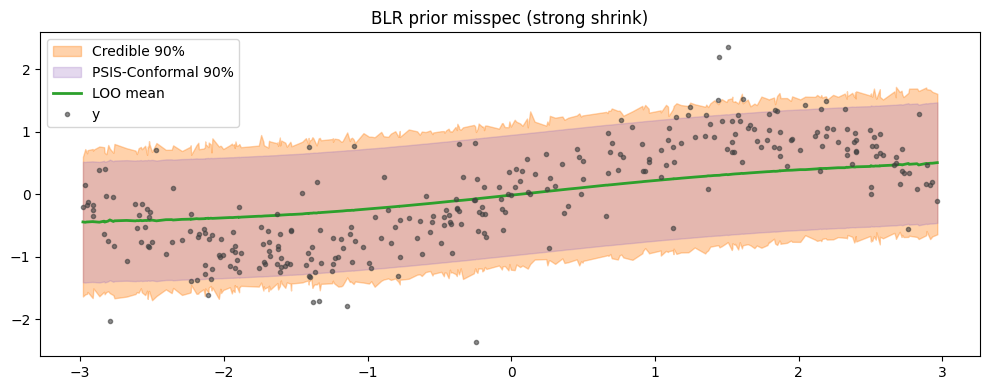

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from examples.bayes_linreg import posterior_draws_and_loglik, posterior_draws_loglik_and_pred
from bartpy import loo_residuals_via_psis, conformal_quantile, build_intervals

# 1) 데이터 (sin + t-노이즈: likelihood도 헤비테일 → prior 미스스펙 효과가 더 잘 드러남)
rng = np.random.default_rng(123)
n = 300
X = rng.uniform(-3, 3, size=(n,1))
f_true = np.sin(X[:,0])
y = f_true + rng.standard_t(df=3, size=n)*0.25

# 2) BLR posterior (강한 수축 prior: tau2 매우 작게)
y_obs, f_draws, loglik, y_pred = posterior_draws_loglik_and_pred(
    X, y, S=1000, tau2=1e-3, a0=2.0, b0=1.0, seed=7
)

# 3) Credible 90%
lo_cr = np.percentile(y_pred, 5, axis=1)
hi_cr = np.percentile(y_pred, 95, axis=1)
cov_cr = np.mean((y_obs >= lo_cr) & (y_obs <= hi_cr))

# 4) PSIS-LOO 잔차 → Conformal 90%
residuals, k_psis, loo_mean = loo_residuals_via_psis(y_obs, f_draws, loglik)
q = conformal_quantile(residuals, alpha=0.1)
lo_pc, hi_pc = build_intervals(loo_mean, q)
cov_pc = np.mean((y_obs >= lo_pc) & (y_obs <= hi_pc))

print(f"BLR strong-shrink prior: credible@90={cov_cr:.3f}, psis@90={cov_pc:.3f}, k_max={np.nanmax(k_psis):.3f}")

# 5) 플롯(오버레이)
order = np.argsort(X[:,0]); x = X[order,0]
plt.figure(figsize=(10,4))
plt.fill_between(x, lo_cr[order], hi_cr[order], color='#ff7f0e', alpha=0.35, label='Credible 90%')
plt.fill_between(x, lo_pc[order], hi_pc[order], color='#9467bd', alpha=0.25, label='PSIS-Conformal 90%')
plt.plot(x, loo_mean[order], color='#2ca02c', lw=2, label='LOO mean')
plt.plot(x, y_obs[order], 'o', ms=3, color='0.25', alpha=0.6, label='y')
plt.title('BLR prior misspec (strong shrink)')
plt.legend(); plt.tight_layout(); plt.show()


Starting burn


100%|██████████| 250/250 [00:00<00:00, 429.02it/s]


Starting sampling


100%|██████████| 250/250 [00:00<00:00, 422.91it/s]


Starting burn


100%|██████████| 250/250 [00:00<00:00, 463.37it/s]


Starting sampling


100%|██████████| 250/250 [00:00<00:00, 411.38it/s]


BART shallow-tree prior: psis@90=0.903, k_max=0.413


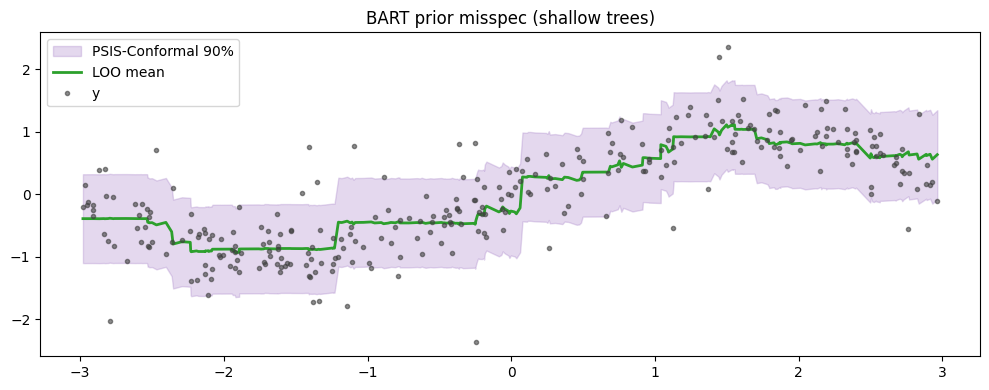

In [3]:
from bartpy.sklearnmodel import SklearnModel
from bartpy import prepare_bart_loglik_and_draws, loo_residuals_via_psis, conformal_quantile, build_intervals

# 1) 같은 데이터 재사용 (X, y)

# 2) BART (얕은 트리 prior + 트리 수 축소)
model = SklearnModel(
    n_trees=20,            # 작게
    n_chains=2,
    n_samples=250,
    n_burn=250,
    thin=0.5,
    alpha=0.85,            # 분할 확률 감소
    beta=5.0,              # 깊이 패널티↑
    store_in_sample_predictions=True,
    store_acceptance_trace=True,
    n_jobs=1
)
model.fit(X, y)

# 3) TRAIN에서 per-sample f, loglik 구성
y_obs_bt, f_draws_bt, loglik_bt = prepare_bart_loglik_and_draws(model)

# 4) PSIS-LOO 잔차 → Conformal 90%
res_bt, k_bt, loo_bt = loo_residuals_via_psis(y_obs_bt, f_draws_bt, loglik_bt)
q_bt = conformal_quantile(res_bt, alpha=0.1)
lo_bt, hi_bt = build_intervals(loo_bt, q_bt)
cov_bt = np.mean((y_obs_bt >= lo_bt) & (y_obs_bt <= hi_bt))

print(f"BART shallow-tree prior: psis@90={cov_bt:.3f}, k_max={np.nanmax(k_bt):.3f}")

# 5) 플롯(오버레이)
order = np.argsort(X[:,0]); x = X[order,0]
plt.figure(figsize=(10,4))
plt.fill_between(x, lo_bt[order], hi_bt[order], color='#9467bd', alpha=0.25, label='PSIS-Conformal 90%')
plt.plot(x, loo_bt[order], color='#2ca02c', lw=2, label='LOO mean')
plt.plot(x, y_obs_bt[order], 'o', ms=3, color='0.25', alpha=0.6, label='y')
plt.title('BART prior misspec (shallow trees)')
plt.legend(); plt.tight_layout(); plt.show()
